In [1]:
# general imports usually needed
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd

In [2]:
# libraries more specific to this lecture notebook
# it is good practice that all imports for most working notebooks usually go at the 
# beginning.  When learning about libraries like scikit-learn, I will put the imports 
# at the top, but also demonstrate and re-import the library where discussed below in the 
# notebook.
import os.path
import sys
sys.path.append('../src')
from ml_python_class.config import DATA_DIR
from ml_python_class.custom_funcs import fetch_compressed_data

from zlib import crc32
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [3]:
# Notebook wide global definitions
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

In [4]:
# notebook wide settings to make plots more readable and visually better to understand
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', titlesize=18)
mpl.rcParams['figure.figsize'] = (10.0, 8.0) # default figure size if not specified in plot

# 2. (Chapter 2) End-to-End Machine Learning Project


**Get the Data**

You will notice that we have abstracted common data acquisition and loading functions to 
our project module.  The module is imported and the functions loaded by default 
that are needed for this notebook.  The `ml_python_class` module contains common 
functions so we don't repeat ourself in notebooks.  Also it will automagically do things like 
determine the correction location of the `DATA_DIR` where data files should be located, even if 
we move around or rearrange notebooks.

In [5]:
# fetch and uncompress housing data if it needs to be downloaded
housing_file = os.path.join(DATA_DIR, 'housing.csv')
fetch_compressed_data(HOUSING_URL, housing_file)

Downloaded data file 'housing.csv' exists, nothing done.


In [6]:
# load the csv file into a pandas DataFrame
housing = pd.read_csv(housing_file)

In [7]:
# sanity check, does it look like we got what we were expecting?
m, n = housing.shape
print(housing.shape)
print(housing.columns)
print("Number of samples in the raw dataset: ", m)
print("Number of feature attributes in the raw dataset: ", n)

(20640, 10)
Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')
Number of samples in the raw dataset:  20640
Number of feature attributes in the raw dataset:  10


### Create a Test Set

We skipped over this section in previous notebook as I think it makes more logical sense 
to introduce it as we start thinking about preparing our data for a machine learning
algorithm.  

There are some subtlities to splitting our data correctly for training that are touched on in 
this section.  As a practical concern, I will usually just use `sklearn` functions to 
randomly split into test and train data sets.  But in a real data analytics project you do 
need to be more careful and make sure your testing data never ever leaks into anything you use 
to train or validate your models, even with repeated loading and splitting.

That said, we can first roll our own function to split a `numpy` array or a `pandas` 
`DataFrame` into test and training sets.  The following illustrates the basic ideas.

Why do we need to do this?  It is important you understand the reasoning.  It is easy to 
build a model that makes perfect predictions on all the data it is trained with.  I could just 
create a lookup table, so any data item I have seen I just return the correct label when you 
ask me to make a prediction.  This will always result in perfect accuracy, or in perfect 
prediction of a real valued target label like a housing price.

The real difficulty is building a model that **generalizes** well to unseen data.  It is 
easy to fool ourselves and thing we are building a hypothesis function that generalizes well.
To not fool ourself, we have to train with only a part of the data, and then evaluate the 
performance of our learned hypothesis function on the data that was not seen during training.
This will give us a better feel for how well our model will work for other data not yet 
gathered or in our data set.

But you have to be even more careful still.  If you want to try out severl different ML 
techniques, and if you always split in different ways into different test and train data sets,
then some of your models will be training with data that others use for testing, and vice versa.
When doing parameter tuning, this kind of **leaking** of things between training and testing can 
cause you to find metaparameters or use ML models that actually still overfit the data

To avoid this type of leaking of information, it is best to absolutely keep some data that is never,
ever, ever used for training in any form.  Its only purpose is to evaluate final models 
for their generalization ability.  This means that while exploring different meta-parameters 
or different ML models, we often then split the training data once again into training and 
validation data.  This allows us to evaluate different models and metaparameters against 
one another, and then get a final judgement on the completely held back test data for final 
evaluations.

So there are some subtle issues involved with train / test / validation data splitting. 
The simplest approach is to simply randomly select some percentage of the samples to be 
the training data, and some percentage for final test.  If your data set never changes, you 
can, as discussed in the text, do something like set the random seed before calling your random 
number generator.  This guarantees you will get the same random test/train split, as long as 
you always have the same data ordered in the same way.

Pythong makes it easy to roll our own train/test split functions.  We could have also passed in
a random seed to the next function, which as you will see is how some of these utility functions 
work in the `sklearn` library.

In [8]:
import numpy as np
np.random.permutation(5)

array([1, 4, 2, 3, 0])

In [9]:
def split_train_test(data, test_ratio):
    """Split a numpy/pandas like array of data into a training and test set.
    The test_ratio determins the ratio or percentage of the samples selected for 
    the testing set.  1-test_ratio samples will thus end up in the training set.
    The data is split randomly between the train and test sets that are returned.
    
    Parameters
    ----------
    data - A numpy array or pandas data frame (narray like object) of data,
       assumed rows are samples and columns are  the features of the data set.
    test_ratio - A float value in range [0.0, 1.0], this will be the ratio of
       the samples slected to be in the resulting  test set.  1-test_ratio
       samples will be randomly selected to be in the training est.
    
    Returns
    -------
    train, test - A tuple of the data is returned splint into a training 
       set and a testing set.
    """
    # randomly shuffle an array of indices from 0 to m-1
    shuffled_indices = np.random.permutation(len(data))
    
    # so that we can use regular array slicing to select 
    # test and train sets of the desired size
    test_set_size = int(len(data) * test_ratio)
    
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    # return the split data using fancy indexing to access the randomly
    # selected indices of the test and training set
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
# as discussed in text, if we always come to this point having loaded the housing data from 
# the same file, and the data has not changed, we can always get the same train/test split by
# setting a random seed before or in the function, before calling the random number generator
np.random.seed(42) # the answer to life, the universe and everything

# do the actual split using our homegrown function for an example
train_set, test_set = split_train_test(housing, 0.2)

print(train_set.shape)
print(test_set.shape)

# what is the expected number of samples in the test set given a 0.2 test_ratio?
print(0.2 * m)

(16512, 10)
(4128, 10)
4128.0


Notice that in this case we got exactly the number of samples, 4128, as we would expect if 20%
are randomly put into the test set and the other 80% into the training set.  The random split
method above guarantees an exact split (unless this is impossible because of an odd number of 
values).  Basically the method above randomly shuffles the indexes 0 to 20639, then uses the
first 20% of these for the test set, and the last 80% for the train set.

If we are worried about information leakage in our training, we might want to try and 
guarantee that we always get the same items in our test and training sets, even if we 
shuffle the data, add new data, etc.  One common but relatively simple way to accomplish this 
is presented in our text.  If each sample has a unique identifier, and if we can hash that 
identifier, we can use the unique id hash to perform a test / train split, but the 
determination will be stable as long as we always use the same test / train split ratio and the 
same hashing function of course.  This is because the unique id does not change, and the hash 
will always hash this id to the same hash value.  

The example implementation below is not guaranteed to get exactly 20% of the values in the 
test set (if that is our test_ratio), because that will depend on the way things end up 
being randomly hashed.  But the split will usually be close enough that it doesn't matter.

You might want to make sure you understand the following 2 functions as a check of how your 
python skills are progressing.  We use an example of the `apply()` function from
`pandas` `Series` items below.  Basically you can think of apply as implementing a loop 
that applies the function to each item of the series, and returns this as a new series
(e.g. as a new attribute column).  So the `apply()` function below does something like:

```python
in_test_set = # New series that is empty but of same size as number of samples

for i,id_ in enumerate(data[id_column]):
    in_test_set[i] = test_set_check(id_, test_ratio)
```

Conceptually the result is an array or a column of booleanr results that is `True` for each 
item that ends up hasing to the test set, and is `False` for each item that ends up hasing 
to the training set.

In [11]:
def test_set_check(identifier, test_ratio):
    """Check a unique identifier and return False if the id hash falls
    within the bottom test_ratio proprotion of the possible hashes.  Return True 
    for the id if its has is above this ratio.  This can be used to 
    reliably split a set of data into a train and test set, and ensure that you always 
    have the same items in the train set and in the test set given the same 
    test_ratio.
    
    Parameters
    ----------
    identifier - A unique identifier for a data item in a dataset
    test_ratio - The ratio of desired test to training items in the resulting split.

    Returns
    -------
    bool - Returns True if the hash of the unique identifier means the item should 
       be in the test set, and False is returned if the item should end up in the 
       training set.
    """
    # crc32 hashes the item, we take bitwise & to get least significant bits 
    # of the resulting hash.  Then the comparison gives true result for those 
    # id hashes that should be in the test set.
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

In [12]:
def split_train_test_by_id(data, test_ratio, id_column):
    """Split numpy/pandas like arrays into training and test sets.
    Data is split randomly by this funciton, but reliably.  e.g. Given 
    the same test_ratio, the same set of items will always end up in the 
    training set and the test set by this split.  This is accomplished 
    by generating a hash on the unique id of each item, and using the hash 
    to perform the train/test split.  The hash is random but should always 
    hash to the same location for the same unique id of a data item.
    
    Parameters
    ----------
    data - A numpy array or pandas data frame (narray like object) of data,
       assumed rows are samples and columns are  the features of the data set.
    test_ratio - A float value in range [0.0, 1.0], this will be the ratio of
       the samples slected to be in the resulting  test set.  1-test_ratio
       samples will be randomly selected to be in the training est.
    id_column - The index of the feature column in the data that should be used 
       as the samples unique id for the split. This can be a string if the 
       data item is a pandas array that has named columns, or an integer 
       index for a numpy like array of data.
       
    Returns
    -------
    train, test - A tuple of the data is returned splint into a training 
       set and a testing set.
    """
    # extract the column of unique ids from the data
    ids = data[id_column]
    
    # use the test_set_check function to hash the unique ids and make an evaluation 
    # for each item whether it is in the test set or not. 
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    
    # return the resulting split by unique id determination
    return data.loc[~in_test_set], data.loc[in_test_set]

There is actually a problem with using a unique id here, as discussed in the text.  We really
don't have one.  We could use latitude and longitude, but the coarseness of the determination 
of district location can mean some of them end up with the same unique id.  This is probably 
not really an issue here for this data.  The example method used here is to use the `pandas`
`reset_index()` to give a unique index number to each sample.  But unless we resave our data 
with this new column added to the raw data, these indexes can change if we for example delete 
items in the middle of the data, or move items around.  If the indexes change, where they 
hash to might change, and thus might end up leaking them to train sets when have been 
used as test items in other locations.

We actually get exactly 4128 items in the test set again, though this is no longer 
guaranteed as discussed above.  Notice also that we now have 11 column attributes after adding 
the unique index column to the `DataFrame`.

In [13]:
# the housing data doens't really have a unique id, so we generate an index column
# All of the above work will go in vain if the order of the items in the raw data file 
# can change between loads, so if adding new items make sure they are added on the end,
# or perhaps it is better to explicitly add the unique id index number to the raw data
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

print(train_set.shape)
print(test_set.shape)

(16512, 11)
(4128, 11)


As mentioned, latitude and longitude should be pretty unique if combined, and probably suitable
for this application.

Notice here we don't get exactly 4128 or 20% of the items in the test set.

In [14]:
# another example, could try and create a unique id using latitude and longitude of the districts
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

print(train_set.shape)
print(test_set.shape)

(16322, 12)
(4318, 12)


'Scikit-learn' has lots of utility functions for doing things like this.  The basic train / 
test split will do exactly what we did in our handmade function.  Notice you can specify the 
`random_state` to this function, to ensure you get the same split given the same input data 
and `test_size` ratio.

In [15]:
# sometimes want to roll by hand, for example if it is really crucial that you always use the same items for training,
# but can use standard library functions
from sklearn.model_selection import train_test_split 

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

print(train_set.shape)
print(test_set.shape)

(16512, 10)
(4128, 10)


Even more subtle issues come into play here when thinking about the test / train data split.
Again if you know some basic statistics and have taken a class you should recognize some of 
these issues.

Basically when we randomly split the data we are taking a random sample.  For some types of 
machine learning problems it might be crucial that the sample used for training is representative
of the data set.  For example, as discussed, we could get unlucky and have no or very few 
examples of houses in an important category, like for example few examples of houses in our 
training data with high median incomes.  Usually random sampling will be fine, especially for 
truly large data sets.  Ours is small enough we might get unlucky.

The solution is to use a more targeted sampling method, like **stratified sampling**.
So if we believe `median_income` is crucial to our model performance, we might want to 
guarantee that our train / test sample split results in a training sample with 
instances that have the same distribution as the overall data set.  For example, we could 
discretize the `median_income` into categories.  The following uses `pandas` `cut()` 
method to discretize the continuous `median_income` attribute into 5 categories, and 
we can see the resulting distribution of incomes for our districts using a 
histogram.

In [16]:
# create an income category with 5 levels
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
                               labels=[1, 2, 3, 4, 5])

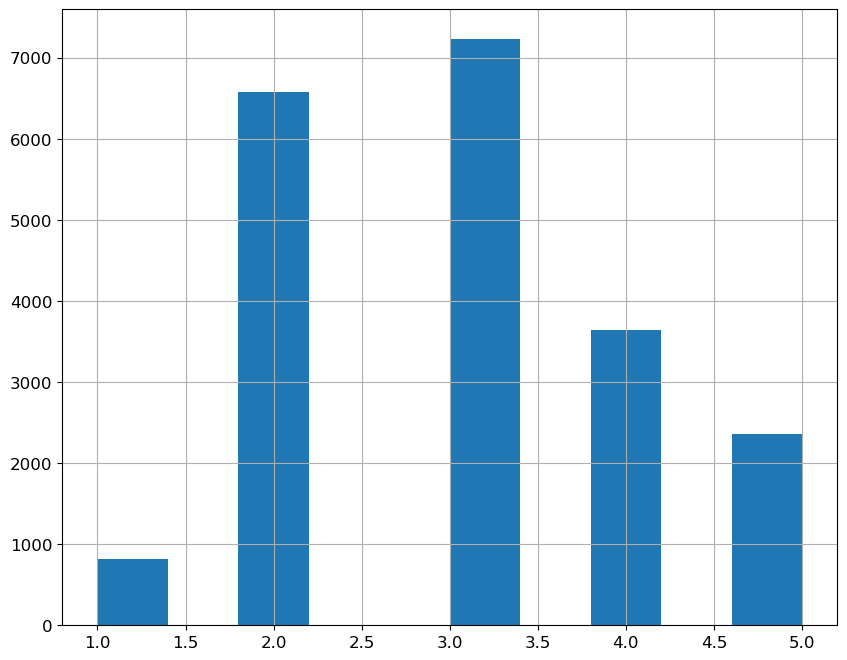

In [17]:
# display the histogram of the housing income categories
housing['income_cat'].hist(figsize=(10,8));

So if we want our resulting training set to have approximately these same ratios of 
`median_income` in the training samples, we could do a stratified sample selection 
using this median income category.  We could roll our own, though it gets a bit 
tricky to guarantee we get a repeatable result that gives both a training and test set with 
approxmatly the same ratios for the stratified sampled categories.  

So we instead use the `sklearn` `StratifiedShuffleSplit` function, which can do all of this, and
can even sample on more than 1 strata.

In [18]:
# a more complex example of sampling.  Use the income category to do the train/test split using 
# stratified shuffling.  This ensure that the same proportions of the categories 
# will be sampled to the train and test data sets
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
print(strat_train_set.shape)
print(strat_test_set.shape)

(16512, 11)
(4128, 11)


In [19]:
strat_train_set[:5]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND,2
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN,5
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND,2
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN,2
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN,3


Out textbook makes a table to prove that the test and training samples have similar distributions
of `median_income` samples.  We can get a feel for if this is true or not by using `value_counts()`
to get the ratios of our income category in the original data before split, and in the resulting 
stratified train and test sets:

In [20]:
# the proportions of the samples in the original and in the test and train set should be similar
housing['income_cat'].value_counts() / len(housing)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

In [21]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [22]:
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

While not complete proof, you should see that within the first 3 most significant digits, all
of these samples have the same proprotion of samples in each of the 5 income categories, which 
is reassuring.

We may be using the stratified train and test samples below, so we will drop the created 
category now in case we want to use these samples below.

In [23]:
# remove the income_cat attribute so data is back to original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)
    
print(strat_train_set.shape)
print(strat_test_set.shape)

(16512, 10)
(4128, 10)


## 2.4 Prepare the Data for Machine Learning Algorithms

Splitting data into training and test sets is a first step to preparing it so we can use it 
to train ML models with.  In this section we look at some of the many other cleaning and scaling 
transformation you will likely need to perform (and many more) before real data is ready 
for ML training and fine-tuning.

As done in the textbook, we first revert to a clean training set.  We will use the stratified 
train / test split sample we performed above.  We also begin to prepare for training by 
dropping the `median_house_value` attribute from our training data, and putting this into 
a separate series/vector.  Thus after this point, we only have the attributes we want to clean 
for training in the `housing` `DataFrame`, and we have the target labels in the `housing_labels`
vector.

In [24]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

print(housing.shape)
print(housing_labels.shape)

(16512, 9)
(16512,)


### Data Cleaning

One of the most troublesome and common things you will have to handle with real data is 
figuring out what to do with missing data.  There is a single attribute `total_bedrooms` that 
is missing a value from a few of the samples.  

The textbook discusses 3 options.  These are by no means the only way to handle missing data.

1. Get rid of the corresponding districts (rows)
2. Get rid of the whole attribute `total_bedrooms` (column)
3. Impute (make up) values in some way

Missing data is important.  We often don't want to just drop the samples, if we don't have a lot 
of data.  Also dropping the column seems extreme, especially if the feature attribute seems like 
it might be useful in forming our hypothesis.  But if we have lots of data we might just do 1 
to get a real clean data set, or if we have a columns that has a lot of missing items, it might 
be useless to try and fill them in with guesses, so we might do 2.

Strategies for imputing data range from the basic (just fill in the the average or median value,
or fill in with a constant like 0), to more complex.  For example, for important attributes, we
might want to try and fill in the missing values with good approximations or guesses to what 
they should have been.  In effect, we want to create another ML model to guess these values using 
the samples we already have.  We could train a ML classifier just on this attribute with only the
samples that have this data, and use this to provide estimates for the missing values.  
For example we might use a simple ML method, like compute similarity of districts, and use the 
K nearest neighbors, say the most similar 3 districts, to average their `total_bedrooms` and use 
that as our guess for one of missing districts bedroom total.

Below we show the `python` code for these 3 options, though all are commented out.  We will
actually use option 3, but demonstrate using `Scikit-Learn` functions to do this kind of
filling in.

In [25]:
# clean the missing data of the total_bedrooms feature

# option 1: get rid of any districts with this feature missing
# housing.dropna(subset=['total_bedrooms'])

# option 2: get rid of of the whole attribute, don't use it for training
# housing.drop('total_bedrooms', axis=1)


# option 3: fill the missing data with some value, the median in this case
#median = housing['total_bedrooms'].median()
#housing['total_bedrooms'].fillna(median, inplace=True)

# i#f you uncommented one of these, you would find that now either we only have a count of 16354
# for all attributes, or that we no longre have a total_bedrooms attribute, or for option 3,
# that now total_bedrooms has a full count of 16512 like all the other attributes
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100


We could have performed option 3 by hand, but if we had other column attributes also with 
missing data, we would have to handle all of them individually.

The `Scikit-Learn` `Imputer` functions allow for more sophisticated missing value corrections.
The `SimpleImputer` can fill in missing values (for all or selected columns) using the median,
mean, a constant, or some other strategies. 

Since the `Imputer` only works for numerical attributes, we have to first create a view of our
data set without the `ocean_proximity` categorical attribute.  Then we can impute the missing
values by filling in the mean.

The fit function actually does not do anything (we will talk more about the `Scikit-Learn` 
API below).  Since we are imputing using the median value, fit simply computes and returns 
the median for each numerical attribute in the data set it is fitting.

In [26]:
# Use Scikit-Learn function for data cleaning
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

# imputer only works with numerical attributes, so create copy of data without categorical features
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)


SimpleImputer(strategy='median')

In [27]:
# for a median imputer, this should simply be the median of each feature
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [28]:
# which should equal the calculated median values
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

To actually perform the imputation, call the transform function.  These steps could have 
been performed together by calling `fit_transform()` on the imputer.

In [29]:
# to actually do the imputation with this sklearn object, have to perform transform
X = imputer.transform(housing_num)

In [30]:
# result is a plain NumPy array, if want features of Pandas dataframe, we can put back into a df
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

Notice now that `total_bedrooms` has a count equal to all th eother attributes.

In [31]:
# notice there are no longer any missing values in total_bedrooms
housing_tr.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,533.939438,1419.687379,497.011810,3.875884
std,2.001828,2.137963,12.574819,2138.417080,410.806260,1115.663036,375.696156,1.904931
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900
25%,-121.800000,33.940000,18.000000,1443.000000,296.000000,784.000000,279.000000,2.566950
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550
75%,-118.010000,37.720000,37.000000,3141.000000,641.000000,1719.000000,602.000000,4.745325
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100


### Scikit-Learn API Design

We will probably have a whole lecture video/section on the `Scikit-Learn` ML library and its 
API later on in the course.  But we have been using some utility functions.  The `SimpleImputer`
is an example of an object that is an estimator and a transformer.  

The `Scikit-Learn` API is well designed and powerful for many reasons.  One of the main reasons 
is because of the **consistency** of the defined interface, and that it uses duck typing instead 
of true object-oriented inheritance to define interfaces that can easily be fit into the 
`sklearn` framework.

- **Estimators** An object that can estimate some parameters based on a dataset is called an
_estimator_.  The imputer we used is an estimator.  The estimation is performed by calling the
`fit()` function, which  takes a dataset (that is row/column like in nature) as its 
input.  For supervised learning algorithms, a second parameter is passed into the `fit()`,
function, the target labels that the estimator is to fit the model to.

- **Transformors** Some estimators can also transform a dataset; these are called transformers.  
A transformer has a `transform()` function that takes a dataset as a parameter and returns 
the transformed dataset.  This transformation generally relies on the learned parameters
that are determined by the estimator from the `fit()` function.
All transformers are estimators.  All have a convenience function called `fit_transform()`
that is equivalent to calling `fit()` followed by `transform()` on the estimator-transformer.

- **Predictors** Some (but not all) estimators are capable of making predictions.  This is the
basis of building the hypothesis function $h$ we discussed earlier.  The hypothesis funciton
is learned by fitting and transforming the dataset to build a model.  Then predictions can be
made on new datasets by calling the `predict()` method that takes a dataset of new instances
and returns the corresponding predictions.

As we will do below to build some pipelines, you can create your own estimator-transformer-predictor object by simply defining a class that implements function with these names taking 
the expected parameters for input (this id duck typing, you don't inherit from a base class, but 
you conform to a defined API).

Some other aspects of the `Scikit-Learn` API design:

- **Inspection** All hyperparameters are accessible directly via public instance variables
(e.g. `imputer.strategy`).  All estimators learned parameters are also accessible via public 
instance variables with an underscore suffix (e.g. `imputer.statistics_`)

- **Nonproliferation of classes**  Originally datasets were only represented as `numpy` arrays,
or `scipy` sparce matrices.  You may notice if you use the lirbary extensively that 
now `pandas` dataframes can be passed in as datasets for input, as they conform to 
an interface to access data by row samples / column attributes.  But any transformations 
will always be returned as a regular `numpy` array or `scipy` sparse matrix.

- **Composition** Existing building blocks are reused as much as possible.  For example 
a data analysis pipeline is a well known concept in data scinece.  a `Pipeline` can be created
in `sklearn` from an arbitrary sequence of transformers follwed by a final estimator (beacause 
the result of calling `fit()` on a transform is a transformed dataset of the same shape, which 
can be passed to the next transformer in the pipeline).

- **Sensible Defaults** `Scikit-Learn` provides reasonable default falues for most parameters, 
making it easy to create a baseline working system quickly.

### Handling Text and Categorical Attributes

We had to leave out the `ocean_proximity` attribute before for the imputer because the 
imputer can only handle numeric data. But categorical data is common, and useful.  But
most machine learning estimators can only use numeric data.

Thus while we want to use categorical data, we have to convert it into numerical representations
if we want to use if for training.



In [32]:
print(housing.shape)
print(housing.columns)

(16512, 9)
Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')


In [33]:
# for ml algorithms need to transform categorical information to numerical labels/categories
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


As we saw before, the `ocen_proximity` category is relatively clean, and it contains 
a finite set of 5 well defined categories.

In [34]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     7277
INLAND        5262
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: count, dtype: int64

Again there are some subtle issues we may need to think about when converting 
categorical data to a numeric representation.  The simplest is to assign an 
arbitrary integer value to each category.  The `sklearn` `OrdinalEncoder` transformer
can do this for us.

In [35]:
# can use Scikit-learn preprocessors for this type of transformation
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

In [36]:
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

You can see by looking before that 0 was assigned to `<1H OCEAN`, 4 was assigned to `NEAR OCEAN`,
etc.  As an example of the transparency we discussed before, the category transformation
parameters are available from this encoder as a public instance variable.  The order of the list
corresponds to the assigned encoding, 0th element first, followed by 1, 2, etc.

In [37]:
# get a list of the categories that were encoded
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

A subtle issue is that ML algorithms will assume or infer some similarity based on 
the numerical ordering.  It will assume `<1H OCEAN` is more similar to `INLAND` than others.
There is maybe a natural ordering to this category, based on distance to (or on) ocean, so 
we might want to force an ordering of closest to furthest:

`[ISLAND, NEAR OCEAN, NEAR BAY, <1H OCEAN, INLAND]`


Given you know all of the unique category identifiers, and you have a particular order you need, 
you can pass in this list to the encoder to have it assign and enforce the particular needed 
ordering:



In [38]:
ordered_categories = [['ISLAND', 'NEAR OCEAN', 'NEAR BAY', '<1H OCEAN', 'INLAND']]
ordinal_encoder_ordered = OrdinalEncoder(categories=ordered_categories)
housing_cat_ordered = ordinal_encoder_ordered.fit_transform(housing_cat)

housing_cat_ordered[:10]

array([[4.],
       [1.],
       [4.],
       [1.],
       [3.],
       [2.],
       [3.],
       [3.],
       [3.],
       [3.]])

In [39]:
# get a list of the categories that were encoded
ordinal_encoder_ordered.categories_

[array(['ISLAND', 'NEAR OCEAN', 'NEAR BAY', '<1H OCEAN', 'INLAND'],
       dtype=object)]

But while this may be the correct solution for this categorical item, some categories really
have no natural ordering or relationship between them.  For example you might consider there 
is a natural order of the category 

`[FRESHMAN, SOPHMORE, JUNIOR, SENIOR]`

in that sequence (or reversed).  But is there any inherent order in say a job title description
category for a set of business data?

`[SALESMAN, RECEPTIONIST, CUSTODIAL, MANAGER, HUMAN RESOURCES, INFORMATION TECHNOLOGY]'

A common solution for categorical data with no inherant order is to encode it using a 
1-hot encoding.  So for example, our attribute with 5 categories would get converted into 
5 column attributes, each representing one of the original categories.  And only 1 of
these columns will be set to 1 for each sample, all others will be 0.

We can use an `sklearn` `OneHotEncoder` to encode into this kind of categorical representation.
The following example should make this clear what we are doing here.

In [40]:
# might want to use one-hot-encoding instead, especially for categorical information without an obvious ordering of
# the numerical mappings
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [41]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [42]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

So notice the encoding transformation results in an array with 5 columns.  Each row only has one of 
the columns set to 1.  The `categories_` shos that column 0 encodes whether less than 1 hour to 
ocean or not, column 1 is whether INLAND or not, etc.

### Custom Transformers

Here we revisit the `Scikit-Learn` API with an example of what we mean by making it easy 
to add our own transformers to the language using Duck typing.
This is the beginning of some more advanced understanding of using the `Scikit-Learn` library. 
We can basically provide our own transformer/estimators by simply creating a class and
defining `fit()`, `transform()` and `fit_transform()` methods.  If the class conform to this
API, can then be used in `Scikit-Learn` pipelines.

Despite what I said, we do also do some formal OO inheritance, inheriting from the 
`BaseEstimator` and the `TransformerMixin` from `sklearn`.  The allows us to inherit
some basic functions.  We could have implemented the `fit_transform()` method ourself, 
just by calling our own `fit()` followed by `transform()`.  The `TransformerMixin` 
basically provides this basic implementation of `fit_transform()`.  The 
`BaseEstimator` addes in `get_params()` and `set_params()` methods to our class that 
we may discuss later.

For example, we might want to have a formal transformer to fit into the `Scikit-Learn` api 
so that we can add in the combined attributes we used earlier.

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin

# indexes of the attributes we are using to create new combined attributes with
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    """Create a new Transformer class to add in combined attributes to the housing
    dataset.  This transformer inherits from both the sklearn BaseEstimator, 
    and the TransformerMixin.  The former automatically creates a `fit_transform()` 
    from our `fit()` and `transform()` methods.  The latter addes in 
    `get_params()` and `set_params()` methods to the transformer.
    """
    
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        """Class meta-parameter add_bedrooms_per_room.  By default this 
        transformer adds this attribute, but we can exclude by setting this 
        class metaparameter to false.
        """
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
        
    def fit(self, X, y=None):
        """Define a fit() function for this transformer.  We don't really have
        anything to do to "fit" this transformer in our case.
        """
        return self # nothing else to do
    
    def transform(self, X, y=None):
        """The purpose of this transformer is to add in the combined attributes
        rooms_per_household, population_per_household, and bedrooms_per_room if 
        desired.
        """
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            # we return the original array X with newly created features concatenated to end 
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            # we return the original array only with the default 2 features concatenated to end
            return np.c_[X, rooms_per_household, population_per_household]

In [44]:
# example of using the transformer to add the 2 attributes, but not the bedrooms_per_room, to the housing data
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

print(housing.shape)
print(housing_extra_attribs.shape)

(16512, 9)
(16512, 11)


### Feature Scaling

Another data preparation we often must deal with is scaling.  We already mentioned that 
some machine learning methods are sensitive to having feature attributes of different scales.
Others can have issues when an attribute has a strange, far from normal distribution.  

There are 2 common ways to get all attributes to the same scale: **min-max scaling** and 
**standardization**.

We can implement both of these by hand relatively easily.  Min-max scaling (also commonly 
called **normalization**) is quite simple, values are shifted and rescaled so they end up
ranging from 0 to 1 (or alternatively from some common minimum value to some common maximum
value).

Using vectorized operations, we can do this for all numerical attributes of a numpy array
very simply, like this:

In [45]:
# use the previous translation with missing values filled in, turn into a numpy array
housing_num = housing_tr.values

# show first 5 samples 
np.set_printoptions(precision=3, suppress=True)
print(housing_num[:5])

# to normalize each column/feature subtracts the minimum value, thus the range is
# shifted from 0 to max
print("Minimum of each feature: ", housing_num.min(axis=0))
housing_num = housing_num - housing_num.min(axis=0)
print(housing_num[:5])
print("Minimum of each feature after shifting: ", housing_num.min(axis=0))

# now if we divide each column by the max, we will rescale all values to the range from 0 to 1:
print("Maximum of each feature: ", housing_num.max(axis=0))
housing_num = housing_num / housing_num.max(axis=0)
print(housing_num[:5])
print("Maximum of each feature after shifting: ", housing_num.max(axis=0))

[[-121.46    38.52    29.    3873.     797.    2237.     706.       2.174]
 [-117.23    33.09     7.    5320.     855.    2015.     768.       6.337]
 [-119.04    35.37    44.    1618.     310.     667.     300.       2.875]
 [-117.13    32.75    24.    1877.     519.     898.     483.       2.226]
 [-118.7     34.28    27.    3536.     646.    1837.     580.       4.496]]
Minimum of each feature:  [-124.35   32.54    1.      6.      2.      3.      2.      0.5 ]
[[   2.89     5.98    28.    3867.     795.    2234.     704.       1.674]
 [   7.12     0.55     6.    5314.     853.    2012.     766.       5.837]
 [   5.31     2.83    43.    1612.     308.     664.     298.       2.375]
 [   7.22     0.21    23.    1871.     517.     895.     481.       1.726]
 [   5.65     1.74    26.    3530.     644.    1834.     578.       3.997]]
Minimum of each feature after shifting:  [0. 0. 0. 0. 0. 0. 0. 0.]
Maximum of each feature:  [   10.04     9.41    51.   39314.    6208.   35679.    5356.  

But if you look at the histograms of these features, you will see that the distributions have 
not changed.  All are now normalized to a range from 0 to 1, but data is still distributed 
exactly in the same shape as before.

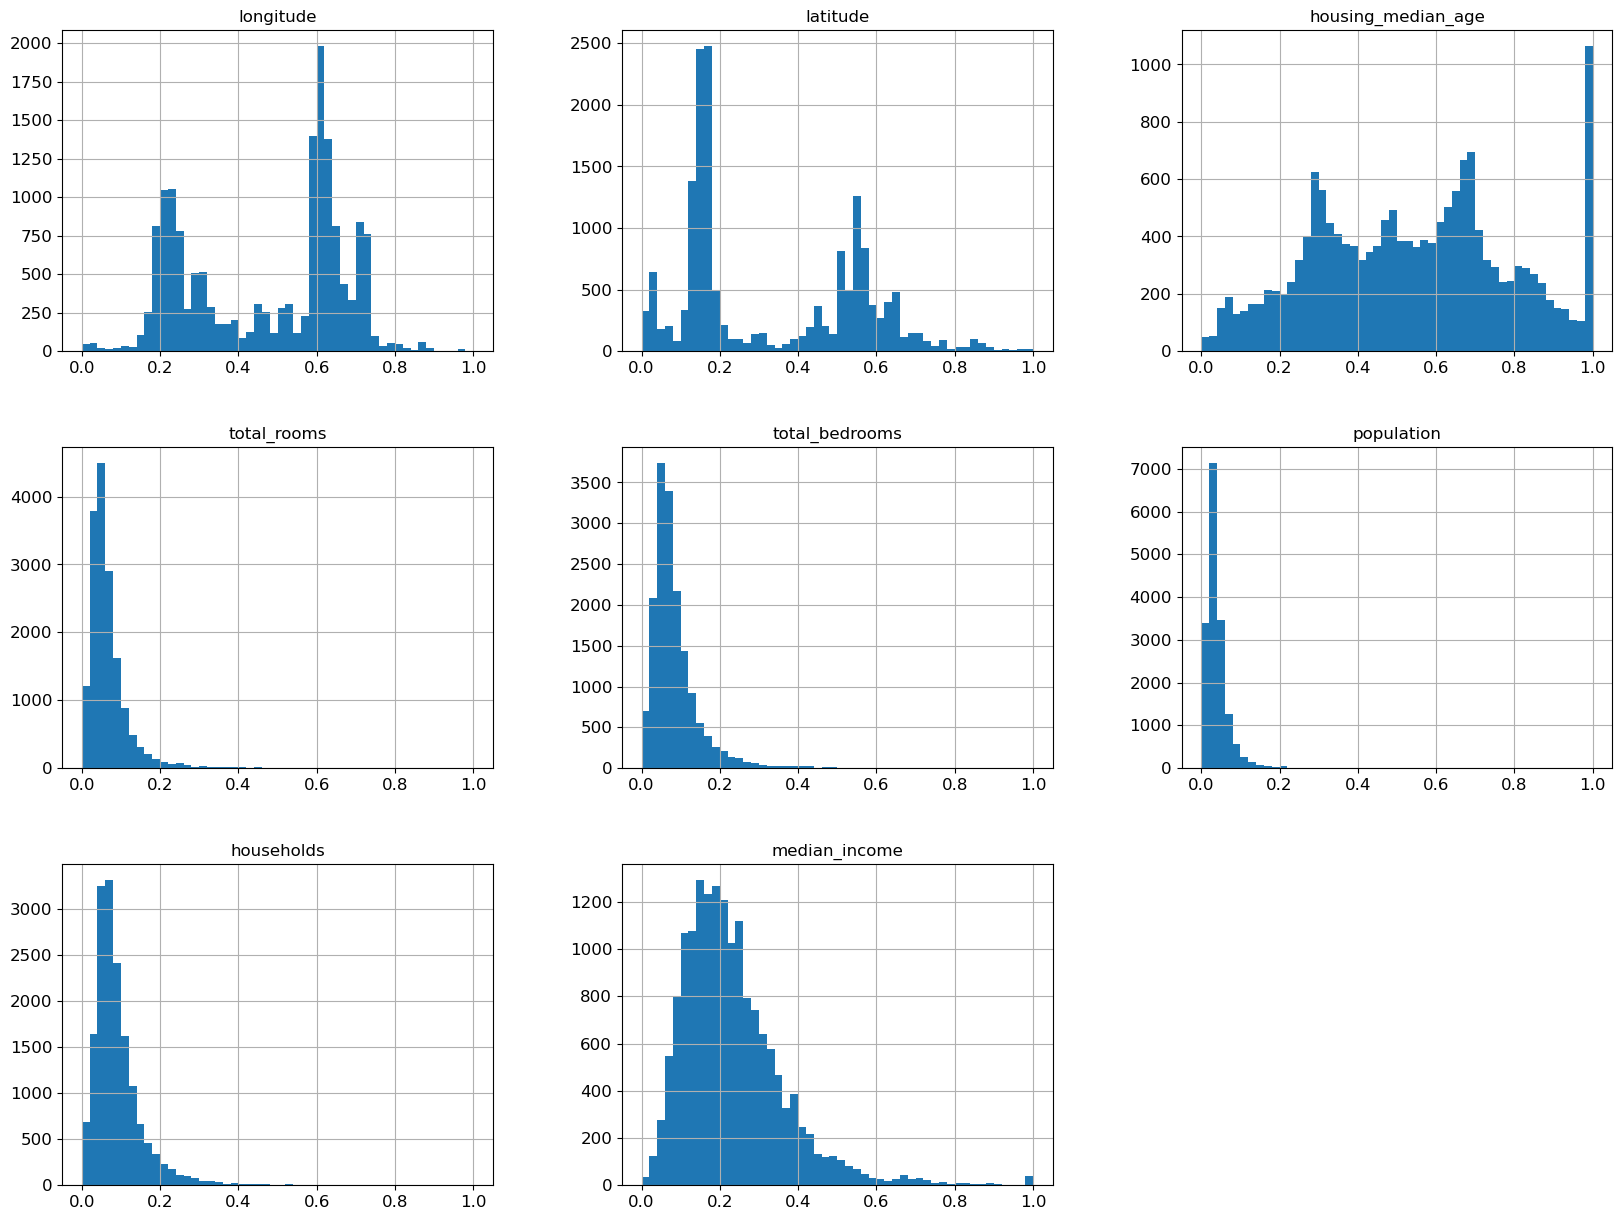

In [46]:
# convert back to a dataframe to visualize
housing_num = pd.DataFrame(housing_num, columns=housing_tr.columns)
housing_num.hist(bins=50, figsize=(20,15));

Standardization does not guarantee values of all attributes are bounded within some specific
range.  Thus for attributes with big outlier values, scaling issues could still be a problem.
The result after standardization is that the distribution will now have a mean of 0
and a standard deviaiton of 1. But as you can see below, the shape of the distributions
are again still the same, we are simply are scaling and shifting the value.  But now most
values will be around 0, and a majority of values will be within the range from -1 to 1.0.

So the steps to do this are the same, but we subtract the `mean()` instead of the minimum for 
the shift, and we divide by the `std()` instead of the max when we scale.

Notice for example with the population attribute, we can end up with values still in a big
range, from about -3 to 30 wheres housing median age is pretty much constrained to the range
-2 to 2.

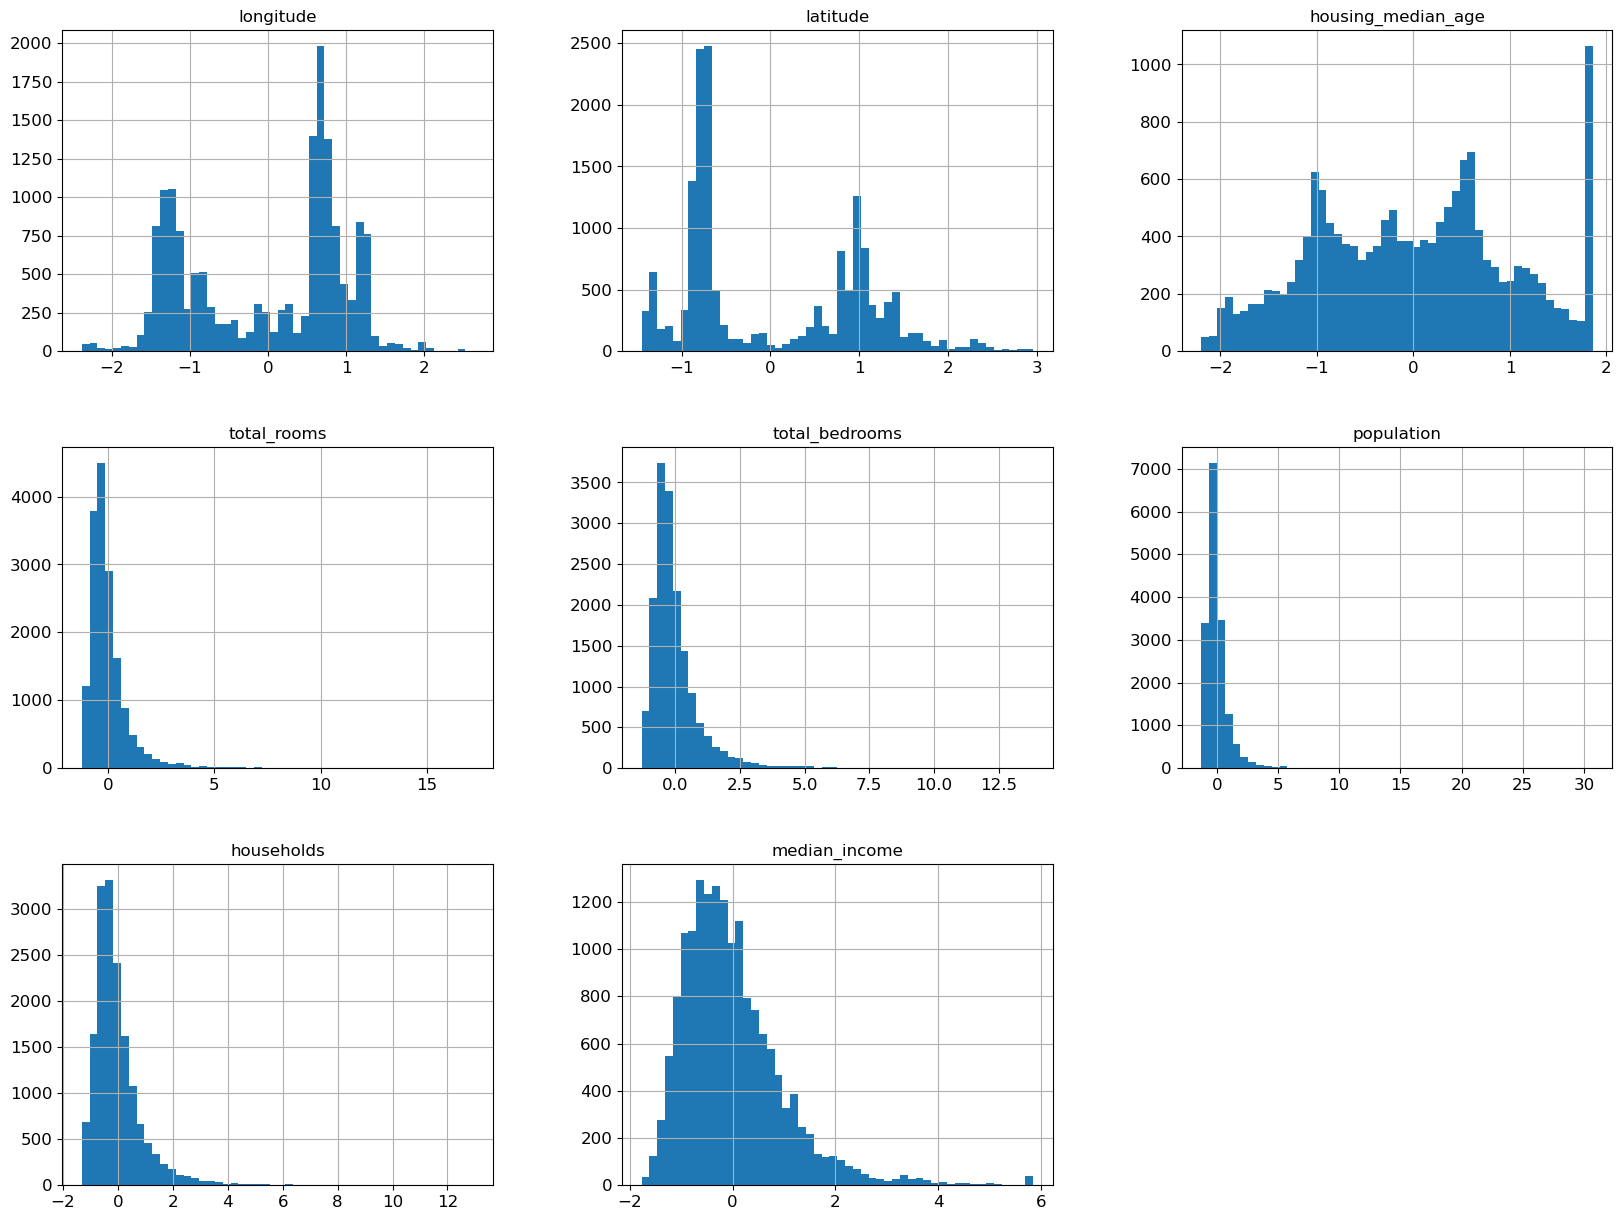

In [47]:
housing_num = housing_tr.values

# shift all attributes to a mean of 0
housing_num = housing_num - housing_num.mean(axis=0)

# rescale the distributions so they all have a standard deviation of 1
housing_num = housing_num / housing_num.std(axis=0)

# convert back to a dataframe to visualize
housing_num = pd.DataFrame(housing_num, columns=housing_tr.columns)
housing_num.hist(bins=50, figsize=(20,15));

### Transformation Pipelines

To finish up this discussion on preparing the data for Machine Learning, lets build a pipeline
to perform needed transformations.  We will use this pipeline for our training and tuning
examples in the next presentation.  First recall that our variable `housing` and `housing_label`
have been set aside.  They were created from the stratified training sample when we 
talked about test / train splits.  We will first create a small pipeline for the numerical 
attributes.  Lets pull the numerical attributes from the clean housing data set again before 
we begin our pipeline transformations.

In [48]:
# just to recall, housing has the original attributes, and we havin't done the 
# data cleaning or scaling on any of it yet.  This is a training set, created from
# the stratified sampling train / test split.  Notice that there are 16512 samples,
# though total_bedrooms has missing data, with 16354 samples only.
print(housing.shape)
housing.describe()
print(housing.columns)

(16512, 9)
Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')


In [49]:
# extract the numerical attribute features for our numerical pipeline
housing_num = housing.drop('ocean_proximity', axis=1)
print(housing.shape)
print(housing.columns)
print(housing_num.shape)
print(housing_num.columns)

(16512, 9)
Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')
(16512, 8)
Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')


First an example pipeline that handles the numerical columns only. 

This pipeline imputes missing values for our `total_bedrooms` attribute.  It is using the 
`CombinedAttributesAdder` transformer we created ourselvs to add in the additnal custom
features that we want to create.  And we use a `StandardScalar` to perform standardized 
scaling on all numerical attributes, resulting in them all having a mean of 0 and a 
standard deviation of 1.

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)


In [51]:
# the data before the scaling and transformations.  Notice the mean and standard deviations, and min 
# and max values range before we do the scaling.  Also notice we are missing values from 
# total_bedrooms
print(housing_num.shape)
housing_num.describe()

(16512, 8)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100


In [52]:
# the data after the scaling and transformations.  Notice the mean and std of the numerical features
# are all 0 and 1 respectively.
# first transform back to a DataFrame so we can call the describe() function
cols = housing_num.columns.append(pd.Index(['rooms_per_household', 'population_per_household', 'bedrooms_per_room']))
housing_num_tr = pd.DataFrame(housing_num_tr, columns=cols)
print(housing_num_tr.shape)
housing_num_tr.describe()

(16512, 11)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04
mean,-5.249246e-15,2.811597e-16,8.778508e-17,-1.549148e-17,-1.358732e-16,6.454785e-19,-1.054282e-17,1.148414e-16,-6.949652e-17,-2.760765e-17,5.732925e-16
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00
min,-2.385075e+00,-1.449702e+00,-2.199176e+00,-1.223624e+00,-1.294906e+00,-1.269855e+00,-1.317625e+00,-1.772289e+00,-1.650308e+00,-2.075331e-01,-2.704506e+00
25%,-1.111200e+00,-7.948529e-01,-8.472270e-01,-5.516115e-01,-5.792186e-01,-5.698016e-01,-5.803051e-01,-6.871505e-01,-3.822298e-01,-5.741455e-02,-5.914140e-01
50%,5.323472e-01,-6.451732e-01,2.756357e-02,-2.354803e-01,-2.457180e-01,-2.291867e-01,-2.369322e-01,-1.755153e-01,-7.966877e-02,-2.406740e-02,-1.630121e-01
75%,7.821265e-01,9.732389e-01,6.637749e-01,2.424578e-01,2.606187e-01,2.682904e-01,2.794582e-01,4.564298e-01,2.358519e-01,1.596537e-02,4.044631e-01
max,2.630493e+00,2.951818e+00,1.856671e+00,1.716156e+01,1.381730e+01,3.071120e+01,1.293901e+01,5.839873e+00,5.225448e+01,1.070603e+02,3.975987e+01


So far we have only done our data preparation and transformations for the numerical 
attributes.  Lets not forget the categorical attribute. 

It would be convenient to have a single transformer pipeline to handle all columns.  
There is a relatively new transformer in `sklearn` that can do just that for us,
the `ColumnTransformer`.  Basically it again takes a sequence of transformer objects, but
we also specify which columns each transformer/pipeline are applied to.

You can pass in a list of integer column indexes if working with `numpy` arrays.
But this transformer also understands `pandas` `DataFrame` objects, in which case you 
can pass in lists of column names as well.

Also note, the `num_pipeline` pipeline transformer we created previously is itself still 
a transformer, albeit one that combines several smaller transformers in a sequence.
But here our full data cleaning transformation pipeline combines the transformer for 
numerical attributes, and the one to handle our categeorical attribute, into a single
transformation pipeline.

In [53]:
from sklearn.compose import ColumnTransformer

# a full pipeline.  We use previous pipeline for numerical attributes, and add in a column transformer to transform the 
# categorical ocean_proximity to a one-hot-encoded set of columns
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

The result of the full data preparation transformation pipeline is a new dataset
with one-hot encoding columns for the `ocean_proximity` attribute, and all 
attributes imputed for missing values, and all attributes scaled using standard
scaling.

In [54]:
print(housing_prepared.shape)

(16512, 16)
